# Final Assignment Agent for HuggingFace Agents Course

This notebooks implements agents to solve subset of [GAIA](https://huggingface.co/spaces/gaia-benchmark/leaderboard) benchmark as described in [Unit 4. Final Project - Create, Test, and Certify Your Agent](https://huggingface.co/learn/agents-course/unit4) of [Agents Course](https://huggingface.co/learn/agents-course) from HuggingFace.

## Analysis of GAIA Challenges for Agent

All questions used to validate agents are available through [Agent Evaluation API](https://agents-course-unit4-scoring.hf.space/docs).

Each evaluation question has:
- task_id - UUID of the task.
- question - Text of the question to be answered by the agent.
- level - complexity of the questions. For this assessment its always 1 but GAIA benchmark has 3 levels.
- file_name - name of the file related to the task. Files can be fetched from Agent Evaluation API endpoint `/files/{task_id}` with `GET` request.

### Gathering Information About Challenges

First, we will gather the evaluation challenges and review them.

Let's prepare environment and install all necessary libraries:

In [1]:
%%capture --no-display

%pip install --upgrade pip
%pip install tqdm openpyxl ipywidgets
%pip install pandas tabulate matplotlib seaborn

%pip install anthropic openai google-genai

Import utility libraries and set up environment variables from `.env` file:

In [1]:
import requests
import os
import sys
import shutil
from pathlib import Path
from dotenv import load_dotenv
from urllib.parse import urljoin
from tqdm import tqdm
import yaml

sys.path.insert(0, str(Path.cwd().parent))
load_dotenv()

True

Create simple models for handling evaluation tasks:

In [2]:
from pydantic import BaseModel, field_serializer
from typing import Optional
from yaml.dumper import SafeDumper
from dataclasses import dataclass


class LiteralString(str):
    """Marker for YAML literal style."""


def _literal_str_representer(dumper, data):
    return dumper.represent_scalar("tag:yaml.org,2002:str", data, style="|")


SafeDumper.add_representer(LiteralString, _literal_str_representer)


@dataclass(frozen=True)
class TaskAttachment(BaseModel):
    url: str
    local_path: str
    mime_type: str


@dataclass(frozen=True)
class Task(BaseModel):
    task_id: str
    question: str
    attachment: Optional[TaskAttachment] = None

    @field_serializer("question")
    def _ser_lit_str_val(self, v: str):
        # wrap the raw string into LiteralString
        return LiteralString(v)


To make it easier to analyze tasks and implement agents, we will download evaluation questions along with any related files.

All data needed for developing agents will be stored in the `data` folder. This keeps the input data separate from any results or output produced by the agents.

More specifically:
- All evaluation task data will be placed inside the `data/tasks` folder.
- A file named `tasks.yaml` will list all the tasks.
- Each subfolder inside the tasks folder will store the data for one specific task. The name of each subfolder will match the `task_id` of that task.

In [3]:
DATA_DIR = "./data"
TASKS_DIR = f"{DATA_DIR}/tasks"

AGENT_EVALUATION_API = "https://agents-course-unit4-scoring.hf.space/"

Functions to fetch tasks lists and associated attachments:

In [ ]:
def get_from_agent_evaluation_api(path: str, stream=True):
    """
    Fetch data from the Agent Evaluation API using GET HTTP Method.
    """
    response = requests.get(
        urljoin(AGENT_EVALUATION_API, path),
        headers={
            "Content-Type": "application/json",
            "Accept": "application/json",
        },
        stream=stream,
    )
    response.raise_for_status()
    return response


def get_tasks_from_agent_evaluation_api():
    """
    Fetch tasks from the Agent Evaluation API.
    """
    response = get_from_agent_evaluation_api("questions")
    tasks = response.json()
    return tasks


def get_task_attachment_from_agent_evaluation_api(task_id: str, local_path: str):
    """
    Fetch task attachment from the Agent Evaluation API.
    """

    with get_from_agent_evaluation_api(f"files/{task_id}", stream=True) as response:
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        total_size = int(response.headers.get("content-length", 0))
        with open(local_path, "wb") as local_file:
            with tqdm.wrapattr(
                response.raw,
                "read",
                total=total_size,
                unit="B",
                unit_scale=True,
                desc=f"💾 Downloading file for task {task_id}",
            ) as raw_read:
                shutil.copyfileobj(raw_read, local_file)
                tqdm.write(f"✅ {local_path}")
        return {
            "url": response.url,
            "local_path": os.path.realpath(local_path),
            "mime_type": response.headers.get("content-type", "text/plain"),
        }

    raise RuntimeError(f"Unable to fetch task attachment for task_id: {task_id}")


Now let's fetch the data from the Agent Evaluation API.

**Note:** This step will delete the existing data folder and replace it with fresh data. Make sure to back up anything important before continuing.

In [ ]:
shutil.rmtree(TASKS_DIR, ignore_errors=True)
os.makedirs(TASKS_DIR, exist_ok=True)

tasks = []
for task_data in get_tasks_from_agent_evaluation_api():
    task_id = task_data["task_id"]
    question = task_data["question"]
    attachment = None
    attachment_name = task_data["file_name"]
    if attachment_name:
        attachment_data = get_task_attachment_from_agent_evaluation_api(
            task_id, f"{TASKS_DIR}/{task_id}/{attachment_name}"
        )
        attachment = TaskAttachment(
            url=attachment_data["url"],
            local_path=f"file://./{os.path.relpath(attachment_data['local_path'], TASKS_DIR)}",
            mime_type=attachment_data["mime_type"],
        )

    task = Task(task_id=task_id, question=question, attachment=attachment)
    tasks.append(task)

tqdm.write(f"💡 {len(tasks)} tasks discovered!")
with open(f"{TASKS_DIR}/tasks.yaml", "w") as tasks_file:
    yaml.safe_dump([task.model_dump() for task in tasks], tasks_file, sort_keys=False)
    tqdm.write(f"✅  {tasks_file.name}")

💾 Downloading file for task cca530fc-4052-43b2-b130-b30968d8aa44: 100%|██████████| 61.6k/61.6k [00:00<00:00, 628kB/s]


✅ ./data/tasks/cca530fc-4052-43b2-b130-b30968d8aa44/cca530fc-4052-43b2-b130-b30968d8aa44.png


💾 Downloading file for task 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3: 100%|██████████| 175k/175k [00:00<00:00, 1.32MB/s]


✅ ./data/tasks/99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3/99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3


💾 Downloading file for task f918266a-b3e0-4914-865d-4faa564f1aef: 100%|██████████| 698/698 [00:00<00:00, 587kB/s]


✅ ./data/tasks/f918266a-b3e0-4914-865d-4faa564f1aef/f918266a-b3e0-4914-865d-4faa564f1aef.py


💾 Downloading file for task 1f975693-876d-457b-a649-393859e79bf3: 100%|██████████| 274k/274k [00:00<00:00, 799kB/s] 


✅ ./data/tasks/1f975693-876d-457b-a649-393859e79bf3/1f975693-876d-457b-a649-393859e79bf3.mp3


💾 Downloading file for task 7bd855d8-463d-4ed5-93ca-5fe35145f733: 100%|██████████| 5.16k/5.16k [00:00<00:00, 2.79MB/s]

✅ ./data/tasks/7bd855d8-463d-4ed5-93ca-5fe35145f733/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
💡 20 tasks discovered!
✅  ./data/tasks/tasks.yaml


To make it easier to understand the tasks during analysis, we’ll display the questions directly in the notebook.

In [4]:
from IPython.display import display, Markdown, Image, Audio
from ipywidgets import HBox, VBox, Layout, Output
import pandas as pd


def display_attachment(att: TaskAttachment):
    mime = att.mime_type
    path = os.path.realpath(
        os.path.join(TASKS_DIR, att.local_path.replace("file://", ""))
    )
    if mime.startswith("text/x-python"):
        text = open(path, encoding="utf-8").read()
        display(Markdown(f"```\n{text}\n```"))
    elif mime.startswith("image/"):
        # img_out = Output(layout=Layout(max_width='200px'))
        # with img_out:
        display(Image(filename=path))
        # display(img_out)
    elif mime.startswith("audio/"):
        display(Audio(filename=path))
    elif os.path.splitext(path)[1] in (".xls", ".xlsx"):
        display(pd.read_excel(path))
    else:
        with open(path, encoding="utf-8") as f:
            text = f.read()
        display(Markdown(f"```\n{text}\n```"))


def display_task(task: Task, extras: list = []):
    # Create Markdown output widget
    left_box = Output(layout=Layout(width="60%", padding="0 20px 0 0"))
    with left_box:
        display(Markdown(f"**Question:**\n\n\n\n{task.question}\n\n**{task.task_id}**"))
        extra_boxes = []
        for extra in extras:
            extra_box = Output(
                layout=Layout(
                    border="1px solid #ccc",
                    padding="10px",
                    margin="10px 0px",
                    gap="20px",
                )
            )
            with extra_box:
                display(extra)
            extra_boxes.append(extra_box)
        if len(extra_boxes) > 0:
            display(VBox(extra_boxes))

    # Create attachment output widget
    right_box = Output(layout=Layout(width="40%"))
    if task.attachment is not None:
        with right_box:
            display_attachment(task.attachment)

    # Combine into a horizontal card layout
    card = HBox(
        [left_box, right_box],
        layout=Layout(padding="10px", margin="10px 0px", gap="20px"),
    )

    display(card)


In [ ]:
for t in tasks:
    display_task(t)

### Baseline for Agents

To assess the gap between frontier models and a general-purpose agent, we will test the models on evaluation tasks without providing any tools. If a task includes an attachment, it will be referenced in the prompt using a public URL. If the chat API supports file attachments, the file will also be included directly.

In [5]:
from pydantic import BaseModel
from collections import defaultdict


class Answer(BaseModel):
    model: str
    answer: str
    input_tokens: int
    output_tokens: int
    reasoning_tokens: int = 0
    latency: int

    @field_serializer("answer")
    def _ser_lit_str_val(self, v: str):
        return LiteralString(v)


def latency_ms(start: float, end: float) -> int:
    return int((end - start) * 1000)


GAIA_BASE_PROMPT = """
You are a general AI assistant.

I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. 

YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. 

If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. 
If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. 
If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.
"""

assessment_results = defaultdict(list)

In [6]:
def answered(task: Task, model) -> bool:
    """
    Check if the task has been answered by the model.
    """
    if not assessment_results[task]:
        return False
    for a in assessment_results[task]:
        if a.model == model:
            return True
    return False

In [ ]:
# tasks = [Task(
#     task_id="test",
#     question="Who are you? One word only.",
#     attachment=None,
# )]

In [ ]:
import anthropic
import base64
import time

client = anthropic.Anthropic()
for model in [
    "claude-3-opus-latest",
    "claude-3-7-sonnet-latest",
    "claude-3-7-sonnet-latest-with-thinking",
    "claude-3-5-haiku-latest",
]:
    for t in tqdm(tasks, desc=f"Answering questions with {model}"):
        if answered(t, model):
            continue

        msg_prts = [{"type": "text", "text": t.question}]
        if t.attachment is not None:
            mime = t.attachment.mime_type
            path = os.path.realpath(
                os.path.join(TASKS_DIR, t.attachment.local_path.replace("file://", ""))
            )
            if os.path.splitext(path)[1] in (".xls", ".xlsx"):
                df = pd.read_excel(path)
                msg_prts.append(
                    {
                        "type": "text",
                        "text": f"<attached_spreadsheet>\n{df.to_markdown()}\n</attached_spreadsheet>",
                    }
                )
            elif mime.startswith("text/"):
                with open(path, encoding="utf-8") as f:
                    att_t = f.read()
                msg_prts.append(
                    {
                        "type": "text",
                        "text": f"<attachment_content>\n{att_t}\n</attachment_content>",
                    }
                )
            elif mime.startswith("image/"):
                with open(path, "rb") as img_f:
                    b = base64.b64encode(img_f.read())
                msg_prts.append(
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": mime,
                            "data": b.decode("utf-8"),
                        },
                    }
                )
            else:
                msg_prts.append(
                    {"type": "text", "text": f"Attachment URL: {t.attachment.url}"}
                )

        if model.endswith("-with-thinking"):
            start_t = time.perf_counter()
            response = client.messages.create(
                model=model.split("-with-thinking")[0],
                thinking={"type": "enabled", "budget_tokens": 1024},
                max_tokens=1024 * 2,
                system=GAIA_BASE_PROMPT,
                messages=[{"role": "user", "content": msg_prts}],
            )
            end_t = time.perf_counter()

            r_text = ""
            for r_prt in response.content:
                if r_prt.type == "thinking":
                    r_text += f"THINKING:\n{r_prt.thinking}\n"
                elif r_prt.type == "redacted_thinking":
                    r_text += "THINKING: Claude's internal reasoning has been hidden for safety reasons.\n"
                elif r_prt.type == "text":
                    r_text += f"ANSWER:\n{r_prt.text}"

            assessment_results[t].append(
                Answer(
                    model=model,
                    answer=r_text,
                    input_tokens=response.usage.input_tokens,
                    output_tokens=response.usage.output_tokens,
                    reasoning_tokens=0,
                    latency=latency_ms(start_t, end_t),
                )
            )
        else:
            start_t = time.perf_counter()
            response = client.messages.create(
                model=model,
                max_tokens=1024,
                system=GAIA_BASE_PROMPT,
                messages=[{"role": "user", "content": msg_prts}],
            )
            end_t = time.perf_counter()

            assessment_results[t].append(
                Answer(
                    model=model,
                    answer=response.content[0].text,
                    input_tokens=response.usage.input_tokens,
                    output_tokens=response.usage.output_tokens,
                    reasoning_tokens=0,
                    latency=latency_ms(start_t, end_t),
                )
            )

In [ ]:
from google import genai as gemini
from google.genai import types as gemini_types
import time

client = gemini.Client()
config = gemini_types.GenerateContentConfig(system_instruction=GAIA_BASE_PROMPT)

for model in ["gemini-2.5-pro-preview-05-06", "gemini-2.0-flash"]:
    for t in tqdm(tasks, desc=f"Answering questions with {model}"):
        if answered(t, model):
            continue

        msg_prts = [t.question]
        if t.attachment is not None:
            mime = t.attachment.mime_type
            path = os.path.realpath(
                os.path.join(TASKS_DIR, t.attachment.local_path.replace("file://", ""))
            )
            if os.path.splitext(path)[1] in (".xls", ".xlsx"):
                df = pd.read_excel(path)
                msg_prts.insert(
                    0,
                    gemini_types.Part.from_bytes(
                        data=df.to_csv(index=False).encode("utf-8"),
                        mime_type="text/csv",
                    ),
                )
            elif mime.startswith("text/"):
                with open(path, encoding="utf-8") as f:
                    att_t = f.read()
                msg_prts.insert(
                    0, f"<attachment_content>\n{att_t}\n</attachment_content>"
                )
            elif (
                mime.startswith("image/")
                or mime.startswith("audio/")
                or mime.startswith("video/")
            ):
                with open(path, "rb") as f:
                    b = f.read()
                msg_prts.insert(
                    0,
                    gemini_types.Part.from_bytes(
                        data=b,
                        mime_type=mime,
                    ),
                )
            else:
                msg_prts.append(f"Attachment URL: {t.attachment.url}")

        start_t = time.perf_counter()
        response = client.models.generate_content(
            model=model,
            config=config,
            contents=msg_prts,
        )
        end_t = time.perf_counter()

        assessment_results[t].append(
            Answer(
                model=model,
                answer=response.text,
                input_tokens=response.usage_metadata.prompt_token_count,
                output_tokens=response.usage_metadata.candidates_token_count,
                reasoning_tokens=response.usage_metadata.thoughts_token_count
                if response.usage_metadata.thoughts_token_count
                else 0,
                latency=latency_ms(start_t, end_t),
            )
        )


In [ ]:
import base64
from openai import OpenAI
import time

client = OpenAI()
for model in [
    "gpt-4.1-mini",
    "gpt-4.1",
    "o4-mini",
    "o1",
]:
    for t in tqdm(tasks, desc=f"Answering questions with {model}"):
        if answered(t, model):
            continue

        msg_prts = [{"type": "input_text", "text": t.question}]
        if t.attachment is not None:
            mime = t.attachment.mime_type
            path = os.path.realpath(
                os.path.join(TASKS_DIR, t.attachment.local_path.replace("file://", ""))
            )
            if os.path.splitext(path)[1] in (".xls", ".xlsx"):
                df = pd.read_excel(path)
                msg_prts.append(
                    {
                        "type": "input_text",
                        "text": f"<attached_spreadsheet>\n{df.to_markdown()}\n</attached_spreadsheet>",
                    }
                )
            elif mime.startswith("text/"):
                with open(path, encoding="utf-8") as f:
                    att_t = f.read()
                msg_prts.append(
                    {
                        "type": "input_text",
                        "text": f"<attachment_content>\n{att_t}\n</attachment_content>",
                    }
                )
            elif mime.startswith("image/"):
                with open(path, "rb") as img_f:
                    b = base64.b64encode(img_f.read())
                msg_prts.append(
                    {
                        "type": "input_image",
                        "image_url": f"data:{mime};base64,{b.decode('utf-8')}",
                    }
                )
            else:
                msg_prts.append(
                    {
                        "type": "input_text",
                        "text": f"Attachment URL: {t.attachment.url}",
                    }
                )

        start_t = time.perf_counter()
        response = client.responses.create(
            model=model,
            instructions=GAIA_BASE_PROMPT,
            input=[{"role": "user", "content": msg_prts}],
        )
        end_t = time.perf_counter()

        assessment_results[t].append(
            Answer(
                model=model,
                answer=response.output_text,
                input_tokens=response.usage.input_tokens,
                output_tokens=response.usage.output_tokens,
                reasoning_tokens=response.usage.output_tokens_details.reasoning_tokens,
                latency=latency_ms(start_t, end_t),
            )
        )

Let's persist LLM answers in `./data/tasks/answers.yaml`):

In [55]:
with open(f"{TASKS_DIR}/answers.yaml", "w") as answers_file:
    yaml.safe_dump(
        {
            str(t.task_id): [a.model_dump() for a in aa]
            for t, aa in assessment_results.items()
        },
        answers_file,
        sort_keys=False,
    )
    tqdm.write(f"✅  {answers_file.name}")


✅  ./data/tasks/answers.yaml


In [38]:
def restore_tasks_from_yaml() -> list[Task]:
    """
    Restore tasks from the YAML file.
    """
    with open(f"{TASKS_DIR}/tasks.yaml", "r") as tasks_file:
        tasks = yaml.safe_load(tasks_file)
        return [Task.model_validate(t) for t in tasks]


def restore_answers_from_yaml() -> dict[str, list[Answer]]:
    """
    Restore answers from the YAML file.
    """
    with open(f"{TASKS_DIR}/answers.yaml", "r") as answers_file:
        answers = yaml.safe_load(answers_file)
        return {
            str(t): [Answer.model_validate(a) for a in aa] for t, aa in answers.items()
        }


tasks = restore_tasks_from_yaml()
answers = restore_answers_from_yaml()
assessment_results = defaultdict(list)
for t in tasks:
    assessment_results[t] = answers[t.task_id]

For visual inspection of the answers run the following script:
Warning: Response is huge.

In [ ]:
for t in tasks:
    extras = []
    for a in assessment_results[t]:
        extras.append(Markdown(f"**{a.model}**:\n\n{a.answer}"))
    display_task(t, extras=extras)

#### Model Answers Summary

To decide on performance of pure LLM we are going to compare it with [ground truth](https://huggingface.co/datasets/gaia-benchmark/GAIA/blob/main/2023/validation/metadata.jsonl).

`gaia-validation-metadata.jsonl` is not part of this repository. To run notebook please download it from [its original location](https://huggingface.co/datasets/gaia-benchmark/GAIA/blob/main/2023/validation/metadata.jsonl). Please do not publish it to not compromise benchmark.

In [ ]:
import json
from collections import defaultdict
import re
import pandas as pd

validation_dataset = defaultdict(str)
with open(f"{DATA_DIR}/gaia-validation-metadata.jsonl", "r", encoding="utf-8") as f:
    for l in f:
        if l.strip():
            t = json.loads(l)
            validation_dataset[t["task_id"]] = t["Final answer"]

fa_marker = "FINAL ANSWER:"
df_dt = []
for t, aa in assessment_results.items():
    gt = validation_dataset[t.task_id].strip()
    for a in aa:
        fa_pos = a.answer.rfind(fa_marker)
        fa_exists = fa_pos != -1
        fa = a.answer[fa_pos + len(fa_marker) :].strip() if fa_exists else ""

        df_dt.append(
            {
                "Task ID": t.task_id,
                "Model": a.model,
                "Answer": fa,
                "Ground Truth": gt,
                "Correct": fa.casefold() == gt.casefold()
                or re.sub(r"\s+", "", fa.casefold())
                == re.sub(r"\s+", "", gt.casefold()),
                "Input Tokens": a.input_tokens,
                "Output Tokens": a.output_tokens,
                "Reasoning Tokens": a.reasoning_tokens,
                "Total Tokens": a.input_tokens + a.output_tokens + a.reasoning_tokens,
                "Latency": a.latency,
            }
        )

df = pd.DataFrame(df_dt)

Display results in tabular format:

In [ ]:
pd.set_option("display.max_rows", None)
display(df)
pd.reset_option("display.max_rows")

Visualize results:

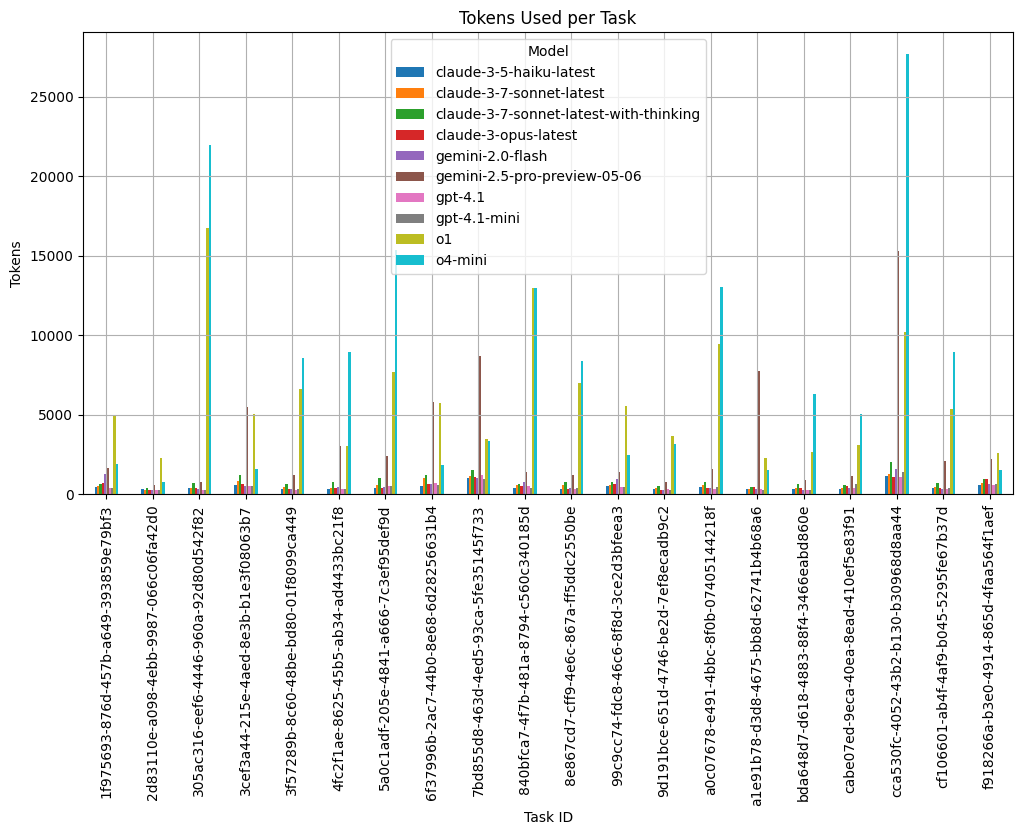

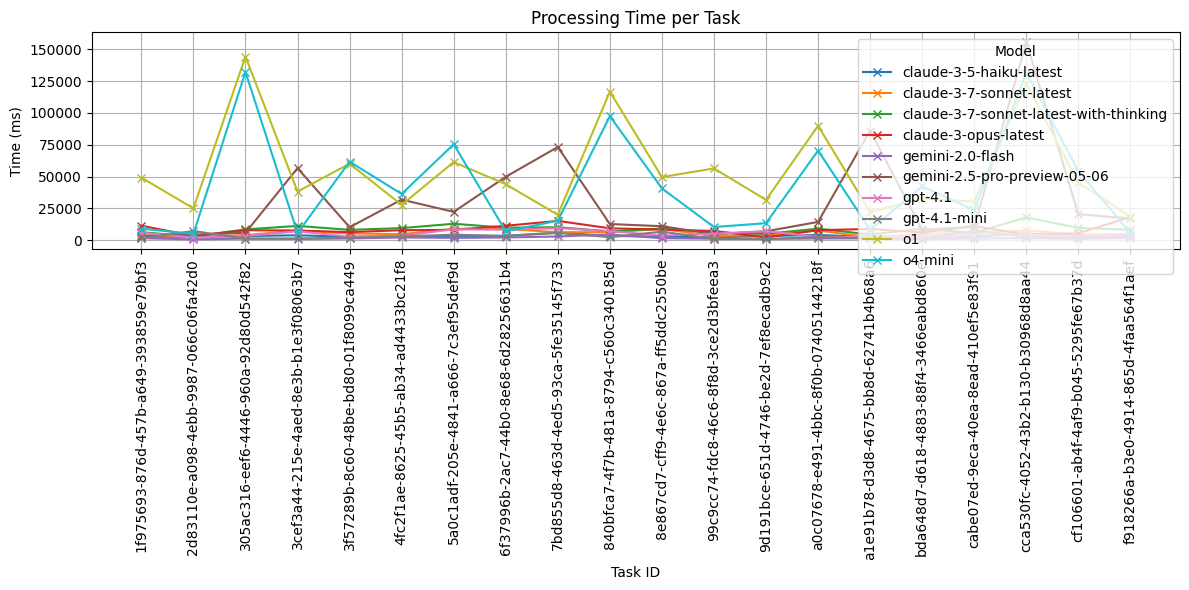

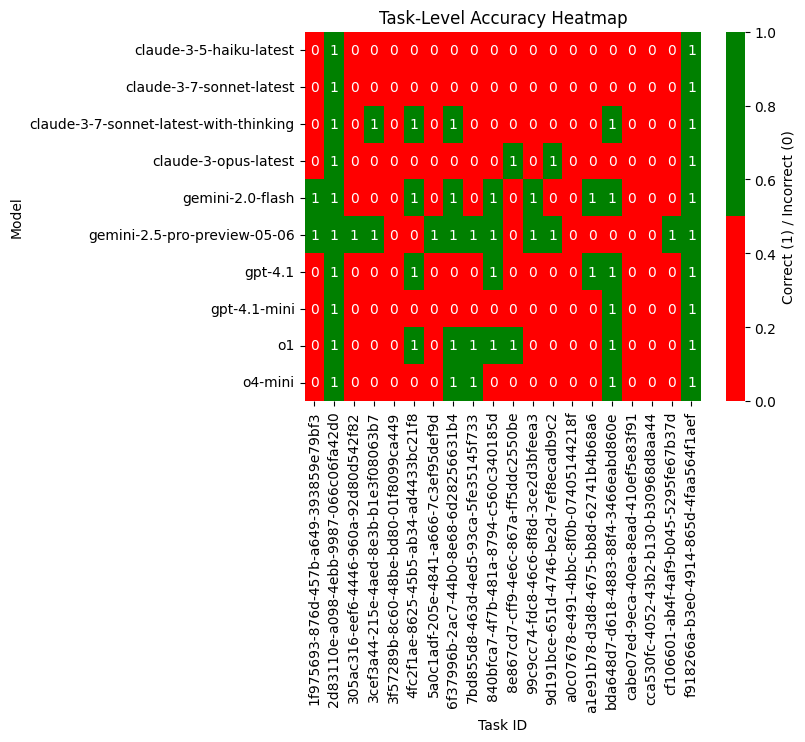

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

tokens = df.pivot(index="Task ID", columns="Model", values="Total Tokens")
tokens.plot(kind="bar", title="Tokens Used per Task", figsize=(12, 6))
plt.ylabel("Tokens")
plt.xlabel("Task ID")
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

latency = df.pivot(index="Task ID", columns="Model", values="Latency")
latency.plot(kind="line", marker="x", title="Processing Time per Task", figsize=(12, 6))
plt.ylabel("Time (ms)")
plt.xlabel("Task ID")
plt.grid(True)
labels = latency.index.tolist()
positions = range(len(labels))

plt.xticks(ticks=positions, labels=labels, rotation=90)
plt.tight_layout()
plt.show()

heatmap_data = df.pivot(index="Model", columns="Task ID", values="Correct")
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap=ListedColormap(["red", "green"]),
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Correct (1) / Incorrect (0)"},
)
plt.title("Task-Level Accuracy Heatmap")
plt.xlabel("Task ID")
plt.ylabel("Model")
plt.xticks(rotation=90)
plt.show()


#### Model Performance

Mean Input Tokens  Mean Output Tokens  \
Model                                                                           
claude-3-5-haiku-latest                            325.95              147.65   
claude-3-7-sonnet-latest                           325.95              270.60   
claude-3-7-sonnet-latest-with-thinking             354.95              501.15   
claude-3-opus-latest                               325.95              215.80   
gemini-2.0-flash                                   397.15              175.25   
gemini-2.5-pro-preview-05-06                       369.05              417.40   
gpt-4.1                                            306.15              168.20   
gpt-4.1-mini                                       318.60              168.65   
o1                                                 271.85             2893.75   
o4-mini                                            320.70             3744.95   

                                        Mean Reasoning Tokens  \
Model                                                           
claude-3-5-haiku-latest                                   0.0   
claude-3-7-sonnet-latest                                  0.0   
claude-3-7-sonnet-latest-with-thinking                    0.0   
claude-3-opus-latest                                      0.0   
gemini-2.0-flash                                          0.0   
gemini-2.5-pro-preview-05-06                           2490.3   
gpt-4.1                                                   0.0   
gpt-4.1-mini                                              0.0   
o1                                                     2857.6   
o4-mini                                                3699.2   

                                        Mean Total Tokens  Mean Latency (ms)  \
Model                                                                          
claude-3-5-haiku-latest                            473.60            3407.85   
claude-3-7-sonnet-latest                           596.55            5670.65   
claude-3-7-sonnet-latest-with-thinking             856.10            8594.80   
claude-3-opus-latest                               541.75            8450.95   
gemini-2.0-flash                                   572.40            1685.25   
gemini-2.5-pro-preview-05-06                      3276.75           30308.30   
gpt-4.1                                            474.35            4943.70   
gpt-4.1-mini                                       487.25            3106.65   
o1                                                6023.20           54333.15   
o4-mini                                           7764.85           42317.45   

                                        Correct Answers  
Model                                                    
claude-3-5-haiku-latest                               2  
claude-3-7-sonnet-latest                              2  
claude-3-7-sonnet-latest-with-thinking                6  
claude-3-opus-latest                                  4  
gemini-2.0-flash                                      9  
gemini-2.5-pro-preview-05-06                         12  
gpt-4.1                                               6  
gpt-4.1-mini                                          3  
o1                                                    8  
o4-mini                                               5

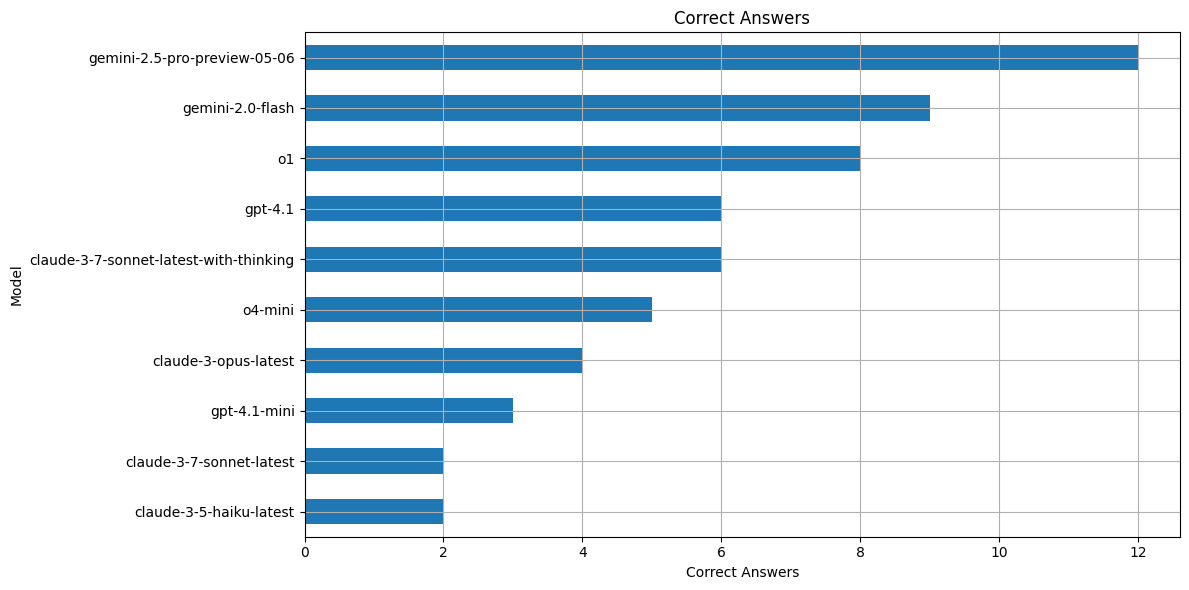

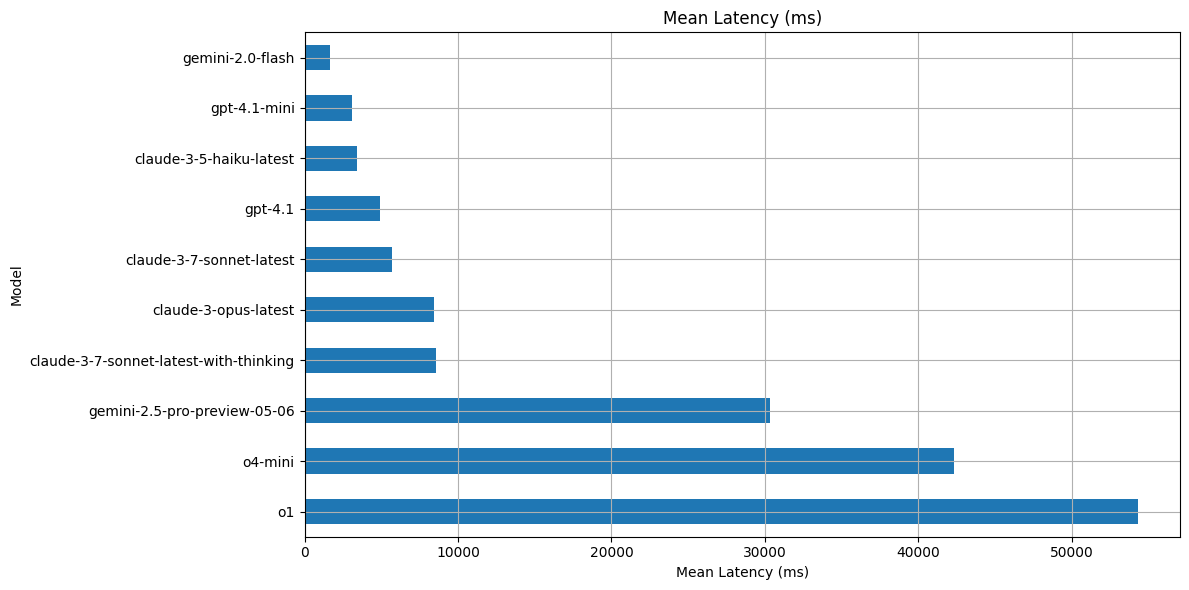

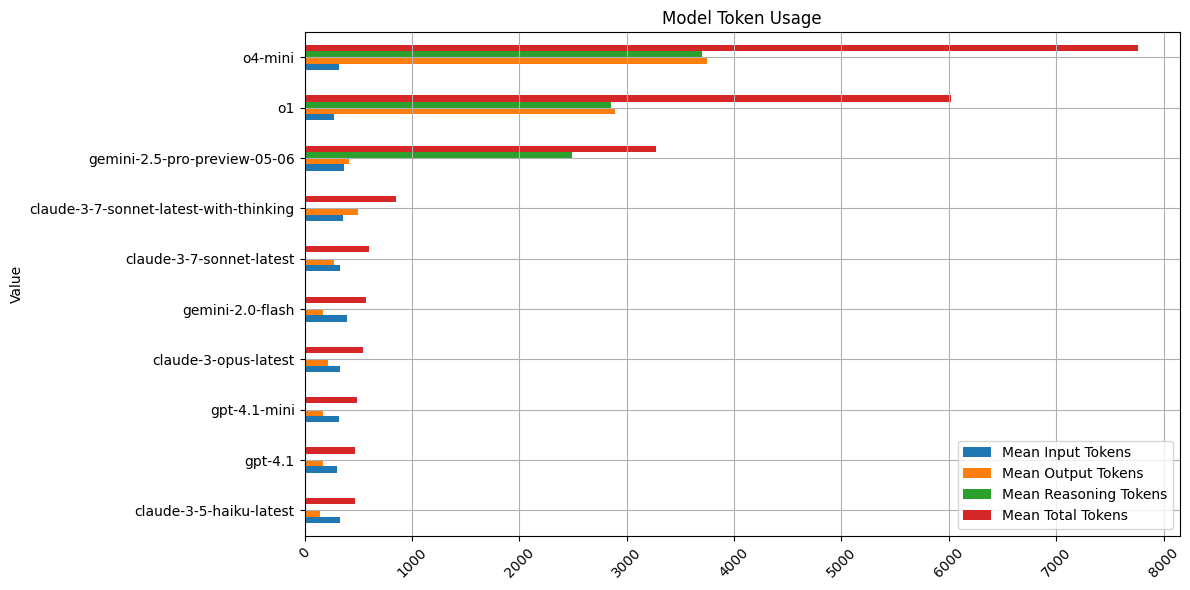

In [ ]:
import matplotlib.pyplot as plt

model_stats = (
    df.groupby("Model")
    .agg(
        {
            "Input Tokens": "mean",
            "Output Tokens": "mean",
            "Reasoning Tokens": "mean",
            "Total Tokens": "mean",
            "Latency": "mean",
            "Correct": "sum",
        }
    )
    .rename(
        columns={
            "Input Tokens": "Mean Input Tokens",
            "Output Tokens": "Mean Output Tokens",
            "Reasoning Tokens": "Mean Reasoning Tokens",
            "Total Tokens": "Mean Total Tokens",
            "Latency": "Mean Latency (ms)",
            "Correct": "Correct Answers",
        }
    )
)
display(model_stats)

for column in ["Correct Answers", "Mean Latency (ms)"]:
    if "Tokens" in column:
        continue
    sorted_data = model_stats[column].sort_values(ascending=column == "Correct Answers")
    sorted_data.plot(kind="barh", figsize=(12, 6), title=column)
    plt.xlabel(column)
    plt.ylabel("Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

model_stats.loc[:, model_stats.columns.str.contains("Tokens")].sort_values(
    by="Mean Total Tokens", ascending=True
).plot(kind="barh", figsize=(12, 6), title="Model Token Usage")
plt.ylabel("Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Task Complexity

Mean Input Tokens  Mean Output Tokens  \
Task ID                                                                       
cca530fc-4052-43b2-b130-b30968d8aa44              977.9              2173.8   
a0c07678-e491-4bbc-8f0b-07405144218f              226.7              1294.1   
3f57289b-8c60-48be-bd80-01f8099ca449              201.1               896.6   
cabe07ed-9eca-40ea-8ead-410ef5e83f91              238.5               557.5   
305ac316-eef6-4446-960a-92d80d542f82              206.2              2048.7   
5a0c1adf-205e-4841-a666-7c3ef95def9d              213.5              1436.8   
cf106601-ab4f-4af9-b045-5295fe67b37d              220.5               861.5   
8e867cd7-cff9-4e6c-867a-ff5ddc2550be              213.1               931.4   
3cef3a44-215e-4aed-8e3b-b1e3f08063b7              411.1               550.0   
a1e91b78-d3d8-4675-bb8d-62741b4b68a6              213.3               298.5   
99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3              540.9               460.1   
1f975693-876d-457b-a649-393859e79bf3              530.2               432.8   
9d191bce-651d-4746-be2d-7ef8ecadb9c2              219.0               408.5   
7bd855d8-463d-4ed5-93ca-5fe35145f733              629.6               792.6   
840bfca7-4f7b-481a-8794-c560c340185d              244.0              1518.6   
4fc2f1ae-8625-45b5-ab34-ad4433bc21f8              197.9               789.7   
6f37996b-2ac7-44b0-8e68-6d28256631b4              328.3               762.8   
bda648d7-d618-4883-88f4-3466eabd860e              211.4               550.0   
f918266a-b3e0-4914-865d-4faa564f1aef              396.4               449.5   
2d83110e-a098-4ebb-9987-066c06fa42d0              213.0               193.3   

                                      Mean Reasoning Tokens  \
Task ID                                                       
cca530fc-4052-43b2-b130-b30968d8aa44                 3124.7   
a0c07678-e491-4bbc-8f0b-07405144218f                 1230.4   
3f57289b-8c60-48be-bd80-01f8099ca449                  816.2   
cabe07ed-9eca-40ea-8ead-410ef5e83f91                  459.8   
305ac316-eef6-4446-960a-92d80d542f82                 1959.9   
5a0c1adf-205e-4841-a666-7c3ef95def9d                 1285.1   
cf106601-ab4f-4af9-b045-5295fe67b37d                  858.6   
8e867cd7-cff9-4e6c-867a-ff5ddc2550be                  829.6   
3cef3a44-215e-4aed-8e3b-b1e3f08063b7                  723.9   
a1e91b78-d3d8-4675-bb8d-62741b4b68a6                  886.6   
99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3                  389.3   
1f975693-876d-457b-a649-393859e79bf3                  328.8   
9d191bce-651d-4746-be2d-7ef8ecadb9c2                  376.8   
7bd855d8-463d-4ed5-93ca-5fe35145f733                  931.1   
840bfca7-4f7b-481a-8794-c560c340185d                 1349.9   
4fc2f1ae-8625-45b5-ab34-ad4433bc21f8                  820.0   
6f37996b-2ac7-44b0-8e68-6d28256631b4                  777.7   
bda648d7-d618-4883-88f4-3466eabd860e                  486.9   
f918266a-b3e0-4914-865d-4faa564f1aef                  299.4   
2d83110e-a098-4ebb-9987-066c06fa42d0                  159.5   

                                      Mean Total Tokens  Mean Latency (ms)  \
Task ID                                                                      
cca530fc-4052-43b2-b130-b30968d8aa44             6276.4            45423.8   
a0c07678-e491-4bbc-8f0b-07405144218f             2751.2            21048.4   
3f57289b-8c60-48be-bd80-01f8099ca449             1913.9            16104.3   
cabe07ed-9eca-40ea-8ead-410ef5e83f91             1255.8            10311.2   
305ac316-eef6-4446-960a-92d80d542f82             4214.8            31215.1   
5a0c1adf-205e-4841-a666-7c3ef95def9d             2935.4            20778.0   
cf106601-ab4f-4af9-b045-5295fe67b37d             1940.6            14924.4   
8e867cd7-cff9-4e6c-867a-ff5ddc2550be             1974.1            14306.3   
3cef3a44-215e-4aed-8e3b-b1e3f08063b7             1685.0            14052.1   
a1e91b78-d3d8-4675-bb8d-62741b4b68a6             1398.

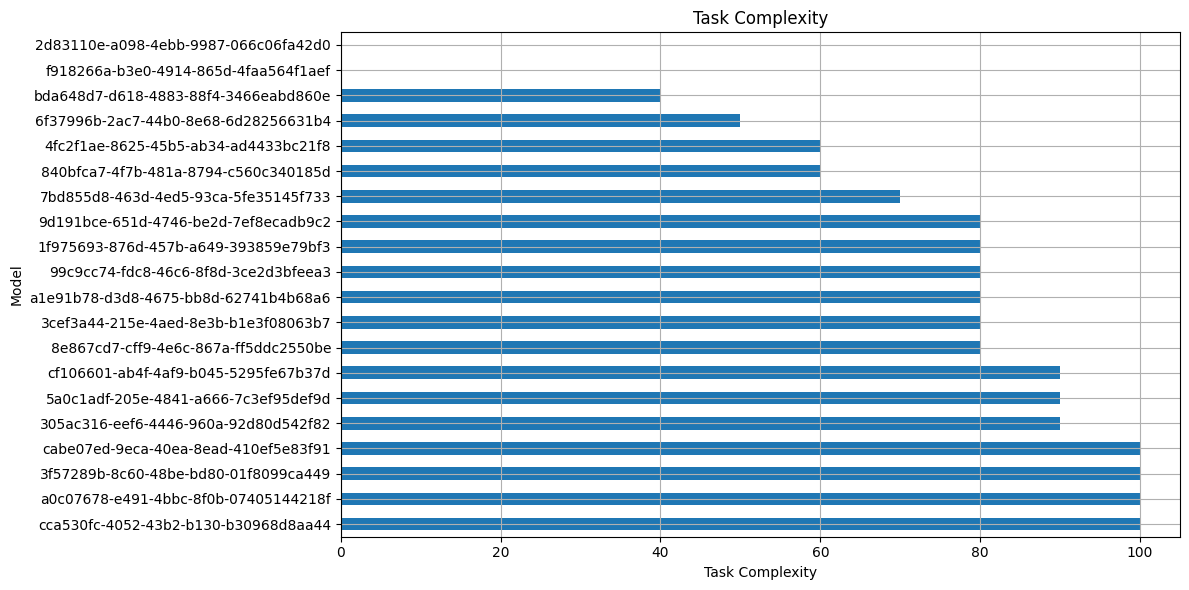

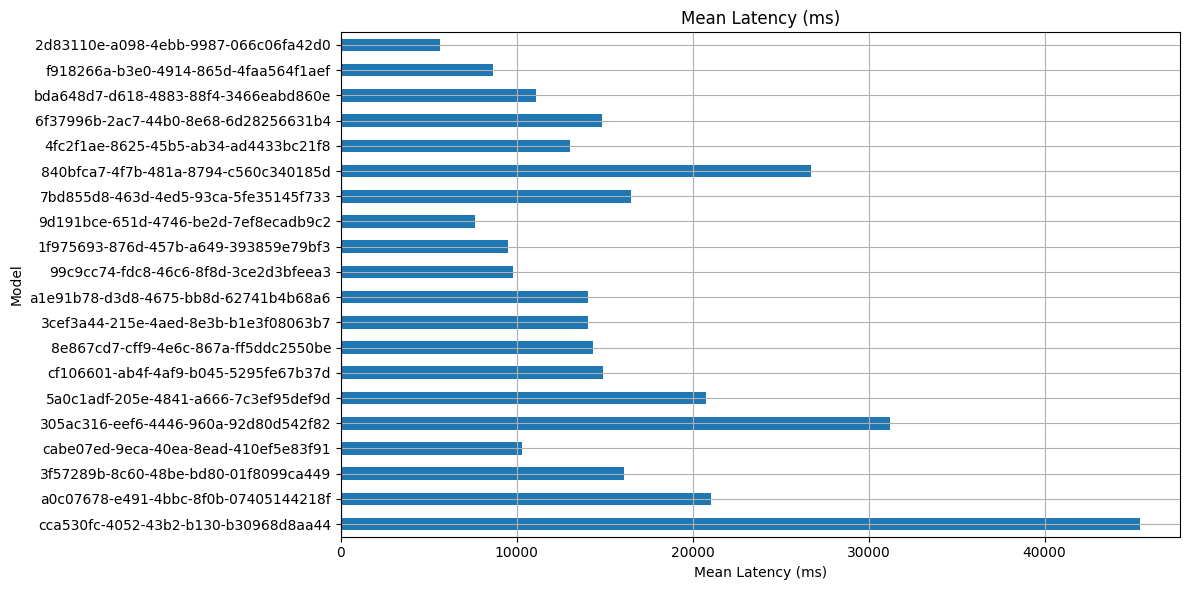

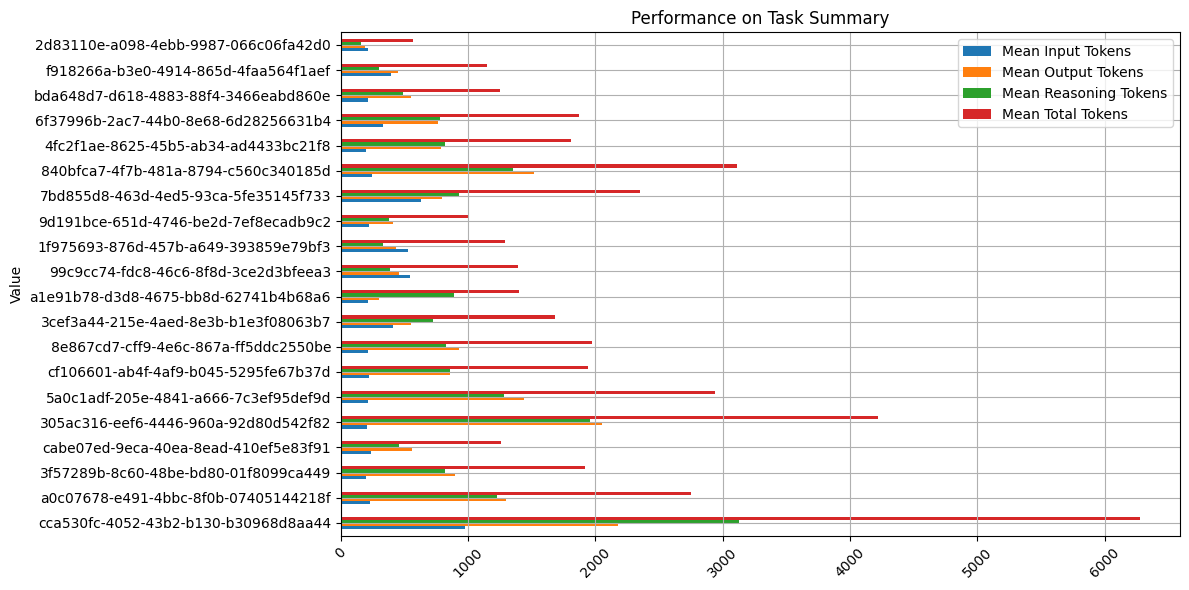

In [ ]:
task_stats = df.groupby("Task ID").agg(
    {
        "Input Tokens": "mean",
        "Output Tokens": "mean",
        "Reasoning Tokens": "mean",
        "Total Tokens": "mean",
        "Latency": "mean",
        "Correct": ["sum", "count"],
    }
)
task_stats.columns = [
    "Mean Input Tokens",
    "Mean Output Tokens",
    "Mean Reasoning Tokens",
    "Mean Total Tokens",
    "Mean Latency (ms)",
    "Correct Count",
    "Total Submissions",
]
task_stats["Task Complexity"] = (
    (task_stats["Total Submissions"] - task_stats["Correct Count"])
    / task_stats["Total Submissions"]
) * 100
task_stats = task_stats.drop(columns=["Total Submissions", "Correct Count"])
task_stats = task_stats.sort_values(
    by=["Task Complexity", "Mean Total Tokens"], ascending=[False, False]
)
display(task_stats)

for column in ["Task Complexity", "Mean Latency (ms)"]:
    task_stats[column].plot(kind="barh", figsize=(12, 6), title=column)
    plt.xlabel(column)
    plt.ylabel("Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

task_stats.loc[:, task_stats.columns.str.contains("Tokens")].plot(
    kind="barh", figsize=(12, 6), title="Performance on Task Summary"
)
plt.ylabel("Value")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Display tasks in descending complexity order:

In [ ]:
from IPython.display import Markdown


def find_task_by_id(task_id: str) -> Task:
    """
    Find a task by its ID.
    """
    for t in tasks:
        if t.task_id == task_id:
            return t
    return None


for t_id in task_stats.index:
    t = find_task_by_id(t_id)
    if t is None:
        continue
    t_complexity = task_stats.loc[t_id, "Task Complexity"]
    display_task(t, extras=[Markdown(f"**Complexity Score**: {t_complexity:.2f}")])

## Agent Implementation
We are going to use HuggingFace [SmallAgents](https://huggingface.co/docs/smolagents/en/index) framework for quick prototyping of the solution. For exploration of different task types please see dedicated notebooks:
- [Chess Exploration](./chess.ipynb)
- [Exploration for Agent Specialized on Data Analysis](./data_analyst.ipynb)
- [Exploration for Speech Recognition](./speech_recognition.ipynb)
- [Exploration for Agent Specialized on Information Retrieval](./information_retrieval.ipynb)
- [Exploration of Working with Youtube Content](./youtube_exploration.ipynb)
- [Multi-agent Configuration Exploration](./multi_agent.ipynb)

Let's put agent developed based on explorations above to work.

In [33]:
from dotenv import load_dotenv
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent))
load_dotenv()

True

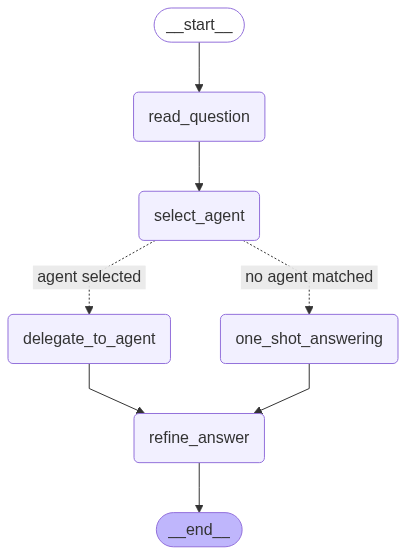

In [8]:
from agents import create_general_ai_agent
from IPython.display import Image, display

gaia = create_general_ai_agent(verbosity=1)
display(Image(gaia.get_graph().draw_mermaid_png()))

In [ ]:
import time
from collections import defaultdict
from tqdm import tqdm

model = "final-assignment-agent-v1"
agent_assessment_results = defaultdict(list)
for t in tqdm(tasks, desc=f"Answering questions with {model}"):
    if not answered(t, model):
        try:
            start_t = time.perf_counter()
            response = gaia.invoke(
                {
                    "task_id": t.task_id,
                    "question": t.question,
                }
            )
            end_t = time.perf_counter()

            answer = Answer(
                model=model,
                answer="\n".join(response["steps"]),
                input_tokens=0,  # not available
                output_tokens=0,  # not available
                reasoning_tokens=0,  # not available
                latency=latency_ms(start_t, end_t),
            )
            assessment_results[t].append(answer)
            agent_assessment_results[t].append(answer)
        except Exception as e:
            tqdm.write(f"Error: {t.task_id} not answered by {model}: {e}")

Now let's review agent answers and compare them with ground truth and answers of LLMs.

### Agent Performance

`gaia-validation-metadata.jsonl` is not part of this repository. To run notebook please download it from [its original location](https://huggingface.co/datasets/gaia-benchmark/GAIA/blob/main/2023/validation/metadata.jsonl). Please do not publish it to not compromise benchmark.

In [ ]:
import json
from collections import defaultdict
import re
import pandas as pd

validation_dataset = defaultdict(str)
with open(f"{DATA_DIR}/gaia-validation-metadata.jsonl", "r", encoding="utf-8") as f:
    for l in f:
        if l.strip():
            t = json.loads(l)
            validation_dataset[t["task_id"]] = t["Final answer"]

fa_marker = "FINAL ANSWER:"
df_dt = []
for t, aa in assessment_results.items():
    gt = validation_dataset[t.task_id].strip()
    for a in aa:
        fa_pos = a.answer.rfind(fa_marker)
        fa_exists = fa_pos != -1
        fa = a.answer[fa_pos + len(fa_marker) :].strip() if fa_exists else a.answer

        df_dt.append(
            {
                "Task ID": t.task_id,
                "Model": a.model,
                "Answer": fa,
                "Ground Truth": gt,
                "Semantically Correct": fa.casefold() == gt.casefold()
                or re.sub(r"\s+", "", fa.casefold())
                == re.sub(r"\s+", "", gt.casefold()),
                "Correct": fa == gt,
                "Input Tokens": a.input_tokens,
                "Output Tokens": a.output_tokens,
                "Reasoning Tokens": a.reasoning_tokens,
                "Total Tokens": a.input_tokens + a.output_tokens + a.reasoning_tokens,
                "Latency": a.latency,
            }
        )

df = pd.DataFrame(df_dt)

In [ ]:
pd.set_option("display.max_rows", None)
# display(df)
display(df[(df["Model"] == "final-assignment-agent-v1") & (df["Correct"] == False)])
pd.reset_option("display.max_rows")

Task ID                      Model  \
197  a0c07678-e491-4bbc-8f0b-07405144218f  final-assignment-agent-v1   

               Answer     Ground Truth  Semantically Correct  Correct  \
197  Yamasaki, Uehara  Yoshida, Uehara                 False    False   

     Input Tokens  Output Tokens  Reasoning Tokens  Total Tokens  Latency  
197             0              0                 0             0   162751

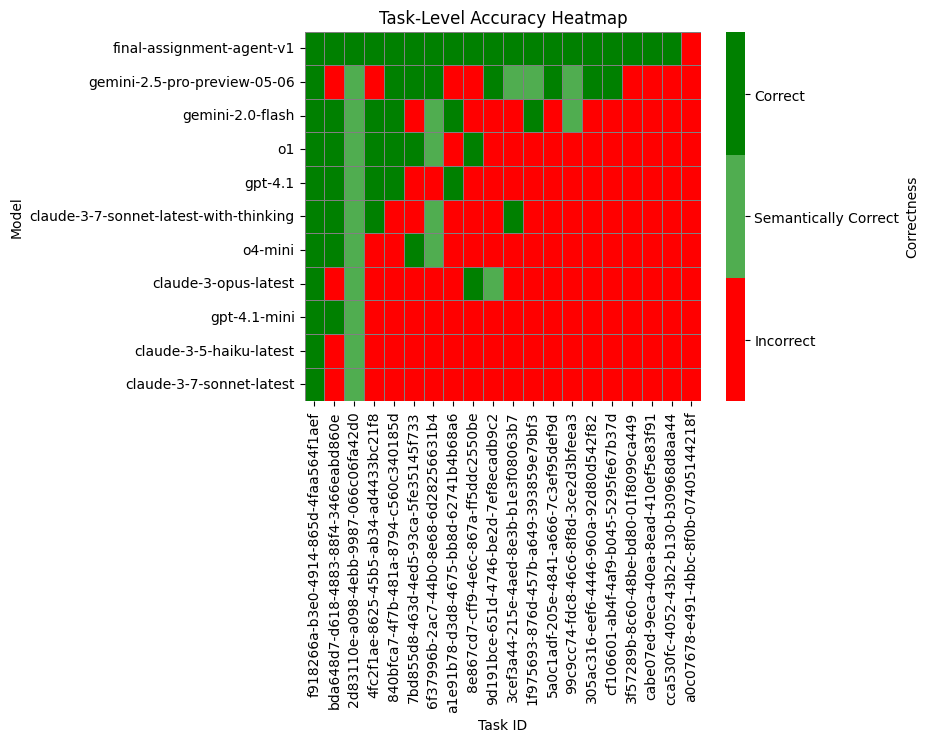

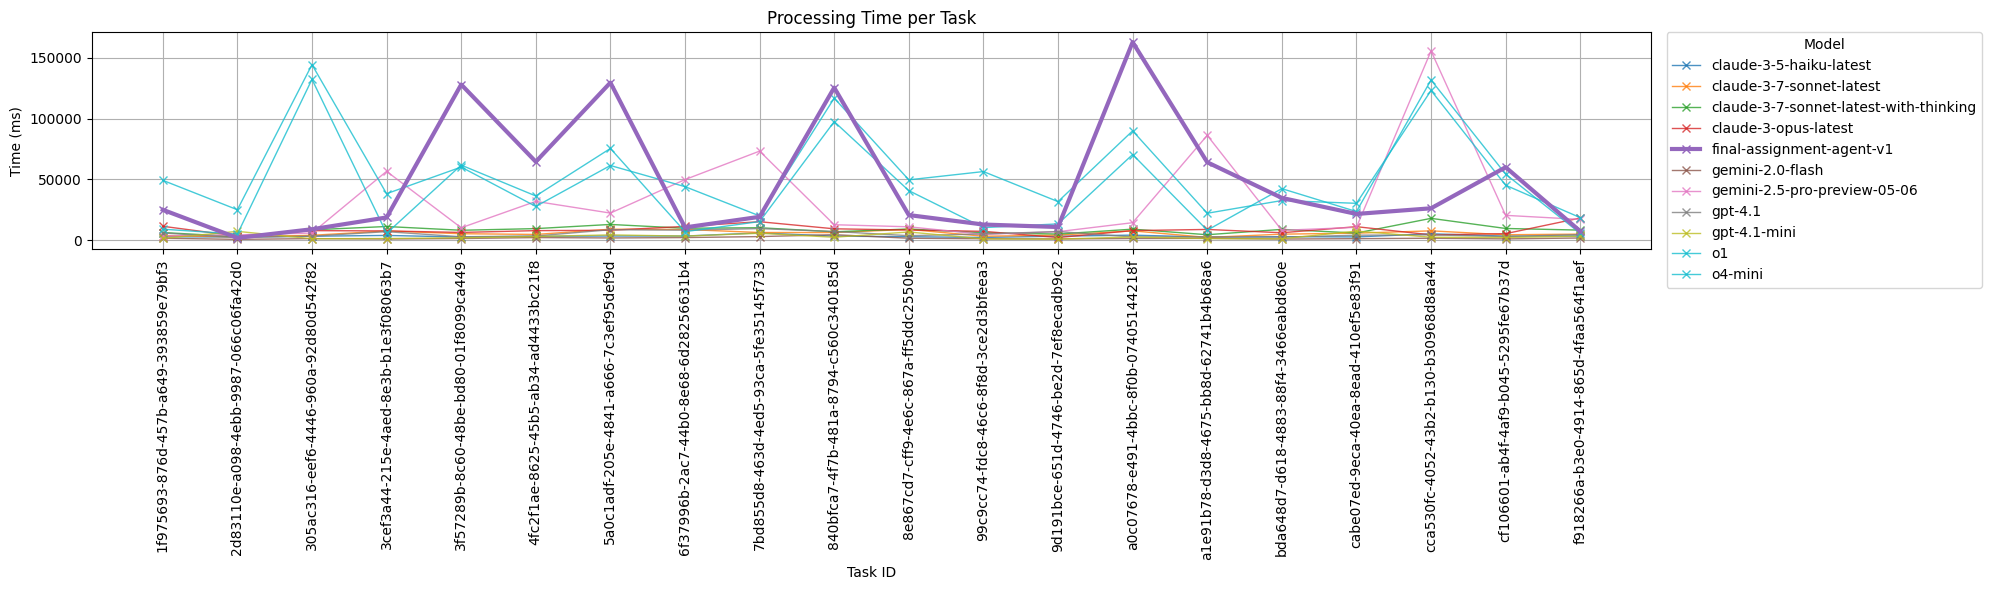

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


# heatmap
def classify(row):
    if row["Correct"]:
        return 2
    elif row["Semantically Correct"]:
        return 1
    else:
        return 0


df["Correctness Level"] = df.apply(classify, axis=1)

model_accuracy = (
    df[df["Correctness Level"] == 2]
    .groupby("Model")
    .size()
    .div(df.groupby("Model").size())
    .sort_values(ascending=False)
)
task_mean_correctness = (
    df.groupby("Task ID")["Correctness Level"].mean().sort_values(ascending=False)
)

heatmap_data = df.pivot(index="Model", columns="Task ID", values="Correctness Level")
heatmap_data = heatmap_data.loc[model_accuracy.index, task_mean_correctness.index]

sns.heatmap(
    heatmap_data,
    annot=False,
    cmap=ListedColormap(["red", "#50ad50", "green"]),
    vmin=0,
    vmax=2,
    cbar_kws={"label": "Correctness"},
    linewidths=0.5,
    linecolor="gray",
)

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([0.33, 1, 1.66])
colorbar.set_ticklabels(["Incorrect", "Semantically Correct", "Correct"])

plt.title("Task-Level Accuracy Heatmap")
plt.xlabel("Task ID")
plt.ylabel("Model")
plt.xticks(rotation=90)
plt.show()

# latency
ax = latency.plot(
    kind="line",
    marker="x",
    title="Processing Time per Task",
    figsize=(20, 6),
    linewidth=1,
    alpha=0.8,
    colormap="tab10",
)

for line, label in zip(ax.get_lines(), latency.columns):
    if label == "final-assignment-agent-v1":
        line.set_linewidth(3)
        line.set_alpha(1.0)
        line.set_zorder(10)

ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left", title="Model", borderaxespad=0)

plt.subplots_adjust(right=0.8)
labels = [task for task in latency.index.tolist()]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("Time (ms)")
plt.xlabel("Task ID")
plt.grid(True)
plt.tight_layout()
plt.show()

# Answers Submission

In [81]:
import requests
from devtools import pprint

answers = []
fa_marker = "FINAL ANSWER:"
for t, aa in assessment_results.items():
    for a in aa:
        if a.model == "final-assignment-agent-v1":       
            fa_pos = a.answer.rfind(fa_marker)
            fa_exists = fa_pos != -1
            fa = a.answer[fa_pos + len(fa_marker) :].strip() if fa_exists else a.answer
            answers.append({
                "task_id": t.task_id,
                "submitted_answer": fa,
            })

submission_data = {
    "username": "vkublytskyi",
    "agent_code": "https://huggingface.co/spaces/vkublytskyi/Final_Assignment_Agent/tree/main",
    "answers": answers,
}

response = requests.post("https://agents-course-unit4-scoring.hf.space/submit", json=submission_data, timeout=60)
response.raise_for_status()
result_data = response.json()
pprint(result_data)

{
    'username': 'vkublytskyi',
    'score': 95.0,
    'correct_count': 19,
    'total_attempted': 20,
    'message': (
        'Score calculated successfully: 19/20 total questions answered correctly (20 valid tasks attempted). High scor'
        'e updated on leaderboard.'
    ),
    'timestamp': '2025-05-19T20:56:40.030859+00:00',
}
